In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)
data_path = os.path.join(root_path, 'data')
model_path = os.path.join(root_path, 'models')

In [2]:
df = pd.read_csv(os.path.join(data_path, 'processed', 'processed.csv'), encoding='utf-8', parse_dates=['date'] )
df.delitos = df.delitos.astype(int)
df.head()

,cod_lugar,cod_subtipo,date,delitos
0,10001-10,R-0,2015-01-01,0
1,10001-10,R-0,2015-02-01,0
2,10001-10,R-0,2015-03-01,0
3,10001-10,R-0,2015-04-01,0
4,10001-10,R-0,2015-05-01,1


In [3]:
df.dtypes

cod_lugar              object
cod_subtipo            object
date           datetime64[ns]
delitos                 int32
dtype: object

In [4]:
df_piv = df.pivot_table(index='date', columns='cod_subtipo', values='delitos', aggfunc='sum')
df_piv.reset_index(inplace=True)
df_piv.columns.name = None
df_piv.set_index('date', inplace=True)
df_piv.head() 

,R-0,R-1,R-10,R-11,R-12,R-13,R-14,R-15,R-16,R-17,R-2,R-3,R-4,R-5,R-6,R-7,R-8,R-9
date,,,,,,,,,,,,,,,,,,
2015-01-01,3720,6291,443,9,3532,271,20,0,22,7016,374,0,274,228,3097,77,51,836
2015-02-01,3385,5811,409,20,3326,249,19,0,1,6982,356,0,321,243,2946,85,68,765
2015-03-01,3582,6055,443,6,3581,238,14,0,0,7563,524,1,392,247,3196,35,88,852
2015-04-01,3584,5428,402,13,3457,196,15,0,2,6985,534,0,316,201,2951,84,82,818
2015-05-01,3555,5640,486,11,3122,202,13,2,3,7398,574,0,440,207,3206,83,83,652


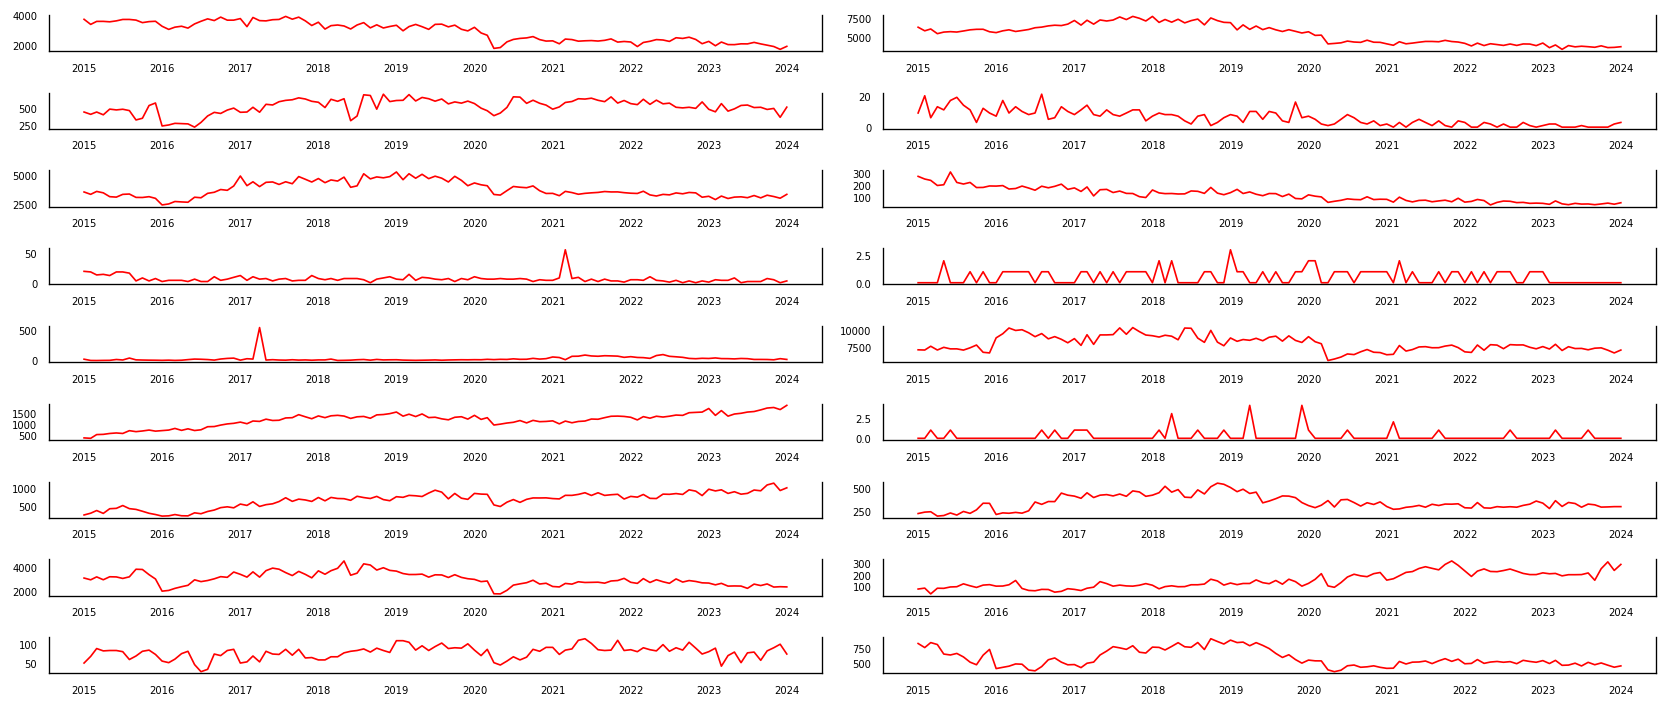

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):
    data = df_piv[df_piv.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()

In [9]:
df_piv_transformed=df_piv.diff().dropna()
train = df_piv[:-12]
test =  df_piv[-12:]
train_transformed = df_piv_transformed[:-12]
test_transformed = df_piv_transformed[-12:]

print(train_transformed.shape, test_transformed.shape)

(96, 18) (12, 18)


In [24]:
from statsmodels.tsa.api import VARMAX, VAR

ar_model = ar_model = VAR(train_transformed)
ar_model = ar_model.fit(maxlags=4, ic='aic')

ar_residuals  = ar_model.resid

In [34]:
import statsmodels.tsa.stattools as sts

def augmented_dickey_fuller_statistics(data, column_name):
    time_series = data[column_name]
    result = sts.adfuller(time_series.values)
    return result[1] <= 0.05

count = 0
for col_name  in ar_residuals.columns:  
    if augmented_dickey_fuller_statistics(ar_residuals, col_name):
        count +=1
count / 18 > 0.5

True

In [37]:
# VMA
ar_residuals_model = VAR(ar_residuals)
ar_residuals_model = ar_residuals_model.select_order(3)
ar_residuals_model.summary()

,AIC,BIC,FPE,HQIC
0,79.18,79.69,2.445e+34,79.38
1,67.19,76.75*,1.710e+29,71.05
2,62.68,81.30,4.353e+27,70.18
3,58.40*,86.08,9.659e+26*,69.56*


In [41]:
ar_residuals_model = VAR(train_transformed)
ar_residuals_model = ar_residuals_model.fit(maxlags=3, ic='aic')

In [102]:
y_fitted = ar_model.fittedvalues
resid_fitted = ar_residuals_model.fittedvalues

In [103]:
y_fitted.index

DatetimeIndex(['2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
      

In [104]:
resid_fitted.index

DatetimeIndex(['2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
      

In [105]:
y_fitted = y_fitted[1:] + resid_fitted

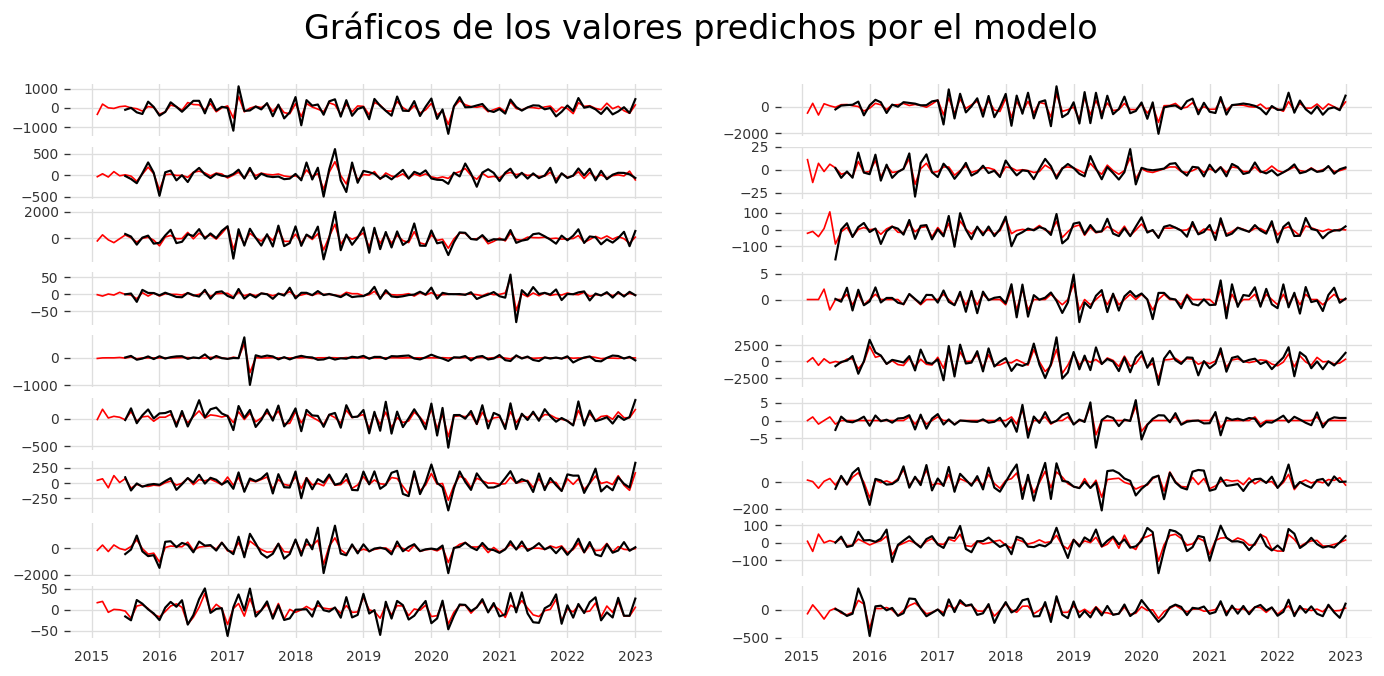

In [107]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    data = train_transformed[train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.plot(y_fitted.iloc[:,i])
plt.show()

In [108]:
p_order = ar_model.k_ar
d_order = 1
q_order = ar_residuals_model.k_ar
n_obs = test_transformed.shape[0]

print('Orden del modelo:', (p_order, d_order, q_order))
print('Observaciones a futuro:', n_obs)


Orden del modelo: (4, 1, 3)
Observaciones a futuro: 12


In [109]:
input_data = train_transformed.values[-p_order:]
resudual_data = ar_residuals.values[-q_order:]

In [110]:
input_data_index = train_transformed.index[-p_order:]
resudual_data_index = ar_residuals.index[-q_order:]

In [111]:
input_data_index

DatetimeIndex(['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01'], dtype='datetime64[ns]', name='date', freq=None)

In [112]:
resudual_data_index.values

array(['2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [113]:
pred = ar_model.forecast(y=input_data, steps=n_obs)
pred_residual = ar_residuals_model.forecast(y=resudual_data, steps=n_obs)

In [114]:
input_data = train_transformed.values[-p_order:]
input_data_index = train_transformed.index[-p_order:]
resudual_data = ar_residuals.values[-q_order:]

pred = ar_model.forecast(y=input_data, steps=n_obs)
pred_residual = ar_residuals_model.forecast(y=resudual_data, steps=n_obs)

pred_index = pd.date_range(start=input_data_index[-1], periods=n_obs+1, freq='MS')[1:]

pred = pred + pred_residual
pred = (pd.DataFrame(pred, index=pred_index, columns=train_transformed.columns + '_pred'))


In [115]:
pred.head()

,R-0_pred,R-1_pred,R-10_pred,R-11_pred,R-12_pred,R-13_pred,R-14_pred,R-15_pred,R-16_pred,R-17_pred,R-2_pred,R-3_pred,R-4_pred,R-5_pred,R-6_pred,R-7_pred,R-8_pred,R-9_pred
2023-02-01,-546.181599,-208.076379,-67.458358,-3.251764,-164.988035,-23.394012,-6.299484,1.886678,-137.347846,774.071343,18.407564,1.201325,-244.469438,58.955827,-628.851021,15.680948,0.851761,109.514977
2023-03-01,-258.316643,-510.182664,65.885401,0.923430,-676.981487,-10.245130,5.661504,-2.597377,-22.478804,-767.053986,-66.831392,-1.637178,-1.298271,-27.368073,-16.525370,-23.912656,6.407098,-24.668688
2023-04-01,-234.960200,-418.146872,-260.931284,-7.131052,-72.362228,-17.828068,0.698109,1.855246,-21.502444,443.670311,-58.842655,0.625398,-48.959398,-81.818695,-1080.744147,-49.860535,-17.216238,-56.596440
2023-05-01,44.535737,171.504689,164.274865,7.269066,242.771195,18.450186,1.447083,-0.341467,10.257730,352.427451,-12.071653,-0.356590,46.306259,9.306469,545.128745,5.286993,-6.991658,-1.799411
2023-06-01,-159.275000,-540.265393,-99.252554,1.131406,-438.668465,-4.079906,-2.662648,-0.592895,-85.336270,360.679639,-75.198473,0.583181,-56.362492,5.647970,-611.574164,10.108307,-4.292700,-114.194824


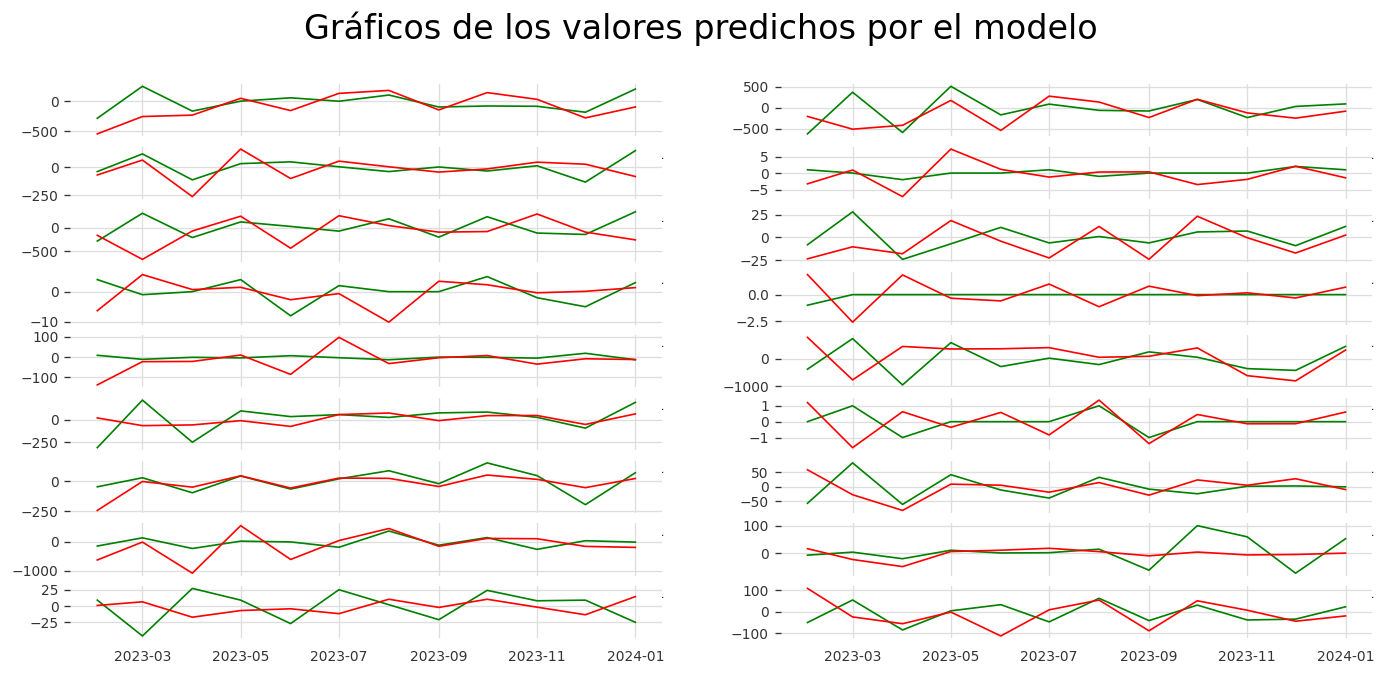

In [116]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    test_data = test_transformed[test_transformed.columns[i]]
    pred_data = pred[pred.columns[i]]
    ax.plot(test_data, color='green', linewidth=1)
    ax.plot(pred_data, color='red', linewidth=1)
    
plt.show()

In [117]:
def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
  return forecast

In [118]:
pred = invert_transformation(train, pred)

In [120]:
pred.head()

,R-0_pred,R-1_pred,R-10_pred,R-11_pred,R-12_pred,R-13_pred,R-14_pred,R-15_pred,R-16_pred,R-17_pred,R-2_pred,R-3_pred,R-4_pred,R-5_pred,R-6_pred,R-7_pred,R-8_pred,R-9_pred
2023-02-01,1721.818401,3966.923621,415.541642,-2.251764,2991.011965,25.605988,-4.299484,2.886678,-103.347846,8288.071343,1717.407564,1.201325,714.530562,396.955827,2040.148979,232.680948,80.851761,647.514977
2023-03-01,1463.501758,3456.740958,481.427043,-1.328334,2314.030478,15.360858,1.362020,0.289300,-125.826651,7521.017357,1650.576173,-0.435853,713.232291,369.587755,2023.623608,208.768293,87.258860,622.846288
2023-04-01,1228.541558,3038.594086,220.495758,-8.459386,2241.668250,-2.467210,2.060129,2.144546,-147.329094,7964.687668,1591.733517,0.189545,664.272893,287.769060,942.879461,158.907758,70.042622,566.249848
2023-05-01,1273.077295,3210.098775,384.770624,-1.190321,2484.439445,15.982976,3.507212,1.803080,-137.071365,8317.115119,1579.661864,-0.167045,710.579153,297.075529,1488.008206,164.194751,63.050964,564.450437
2023-06-01,1113.802295,2669.833382,285.518069,-0.058914,2045.770981,11.903070,0.844564,1.210185,-222.407635,8677.794758,1504.463391,0.416136,654.216661,302.723499,876.434041,174.303058,58.758264,450.255613


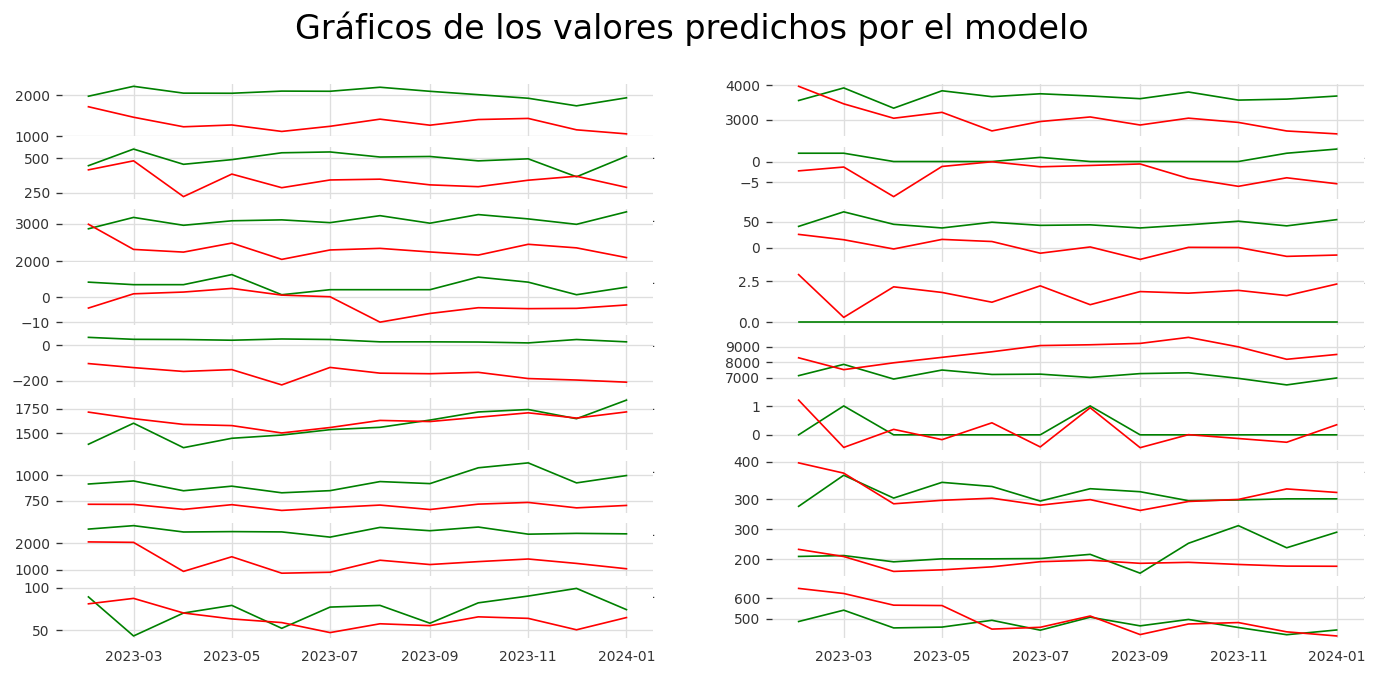

In [119]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    test_data = test[test.columns[i]]
    pred_data = pred[pred.columns[i]]
    ax.plot(test_data, color='green', linewidth=1)
    ax.plot(pred_data, color='red', linewidth=1)
    
plt.show()

Podemos conformarnos con este modelo devido a la falta de tiempo. Veamos como se ven tas predicciones y como podemos desagregar estas por lugares en la siguiente notebook